In [1]:
import xarray as xr 
from dask.distributed import Client
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import glob

## Start here
# Read in ERA5 data

In [2]:
!conda list

# packages in environment at /Users/nalex2023/miniconda3/envs/nma:
#
# Name                    Version                   Build  Channel
abseil-cpp                20230802.0           h313beb8_2  
absl-py                   2.1.0                    pypi_0    pypi
act-atmos                 2.1.0              pyhd8ed1ab_0    conda-forge
affine                    2.4.0                    pypi_0    pypi
aggdraw                   1.3.19                   pypi_0    pypi
aiofiles                  24.1.0                   pypi_0    pypi
aiohttp                   3.9.3                    pypi_0    pypi
aiohttp-cors              0.7.0                    pypi_0    pypi
aiosignal                 1.3.1              pyhd8ed1ab_0    conda-forge
airportsdata              20241001                 pypi_0    pypi
alabaster                 0.7.13                   pypi_0    pypi
annotated-types           0.6.0                    pypi_0    pypi
anyio                     4.3.0                    pypi_0    pyp

In [2]:
#input_dsets = xr.open_dataset('~/Data/final_proc_5yr_6h.nc')
input_dsets = xr.open_mfdataset('/Users/nalex2023/main/tropcyc/archive/atlantic_exps3/Datasets/ERA5_processed_40/final_proc_5yr_6h.nc')



In [4]:
# calculating coriolis parameter 
import numpy as np

cor_parms =  2 * 7.29 * 1e-5 * np.sin(np.radians(input_dsets['latitude']))

input_dsets['cor_params'] = xr.DataArray(cor_parms,
                                            name='cor_params'
                                            ).broadcast_like(input_dsets['r'])



In [5]:

input_dsets = input_dsets.compute()

## Read in IBTRACKS data

In [6]:
#Filepath for IBTRACKS
ib_data = '/Users/nalex2023/main/ml-hurricane-intensity/test_folder/ibtracs.NA.list.v04r00.csv'

In [7]:
from global_land_mask import globe

def process_ibrack(ib_loc, periods=[2000,2005]):

    #Read in the IBTRACKS data
    read_ib_data = pd.read_csv(ib_loc,keep_default_na=False)
    
    #Get the units for each column in read_ib_data
    units = read_ib_data.iloc[0,:]

    #Get data or the remainder of read_ib_data
    ib_original_dft = read_ib_data.iloc[1:,:]

    #Set a custom date and time range based on user choosing
    ib_original_dft['datetime'] = pd.to_datetime(ib_original_dft['ISO_TIME'],format='%Y-%m-%d %H:%M:%S')
    year_mask = (ib_original_dft['datetime'] > f'{periods[0]}-1-1') & (ib_original_dft['datetime'] <= f'{periods[1]}-11-30')
    ib_new_period = ib_original_dft[year_mask][ib_original_dft['BASIN'] == 'NA']

    #Only use cyclones over the North Atlantic basin
    #This can be changed to include more cyclones outside of the Northeast Atlantic
    def only_na_basin(df):
        lon_wise = df.sort_values(by='datetime')
        if lon_wise['LON'].iloc[0] > -55:
            return df
        else:
            return None

    #Get the number of time steps in each cyclone, or event
    only_neatlantic = ib_new_period.groupby('SID').apply(only_na_basin).reset_index(drop=True)
    counts = only_neatlantic.groupby('SID').count().iloc[:,0]
    
    #Get cyclones that last at least 12 time steps
    counts_12 = counts[counts > 12].index
    persist_storms = ib_new_period[ib_new_period['SID'].isin(counts_12)]
    persist_storms['month']= persist_storms['datetime'].dt.month
    
    # mask out land points
    def mask_lands(df):
        ordered_df = df.sort_values(by='datetime')
        lat = ordered_df['LAT']
        lon = ordered_df['LON']
        ocean_mask = pd.Series(globe.is_ocean(lat=lat,lon=lon))
        idx_false = ocean_mask.idxmin()
        if idx_false == 0:
            return df
        else:
            land_mask = ocean_mask.iloc[:idx_false]
            final_masked = ordered_df.iloc[:idx_false,:]
            return final_masked
   
    # filter extratropical parts of the storm tracks
    def filter_ET(df):
        ordered_df = df.sort_values(by='datetime')
        lat_filter = ordered_df['LAT'] <= 35
        filter_df = ordered_df[lat_filter]
        return filter_df
    
    exclude_et = persist_storms.groupby('SID').apply(filter_ET).reset_index(drop=True)

    final_dft = exclude_et.groupby('SID').apply(mask_lands).reset_index(drop=True)

    return final_dft

ib_data_processed = process_ibrack(ib_data,periods=[2000,2005])
ib_data_processed['LAT'] = ib_data_processed['LAT'].astype(float)
ib_data_processed['LON'] = ib_data_processed['LON'].astype(float)
ib_data_processed['USA_WIND'] = ib_data_processed['USA_WIND'].astype(float)
ib_data_processed['datetime'] = pd.to_datetime(ib_data_processed['datetime'],format='%Y-%m-%d %H:%M:%S')
ib_data_processed['SID'] = ib_data_processed['SID'].astype(str)

ib_data_processed['id'] = ib_data_processed['SID'].astype('category')
ib_data_processed['id'] = ib_data_processed['id'].cat.codes
req_cols = ['datetime','LAT','LON','USA_WIND','id']

# groupby datetime 6h 
ib_data_processed['datetime'] = ib_data_processed['datetime'].dt.floor('6h')

ib_data_processed_6h = ib_data_processed[req_cols].groupby('datetime').mean().reset_index()

# copy the SID based on the id

ib_data_processed_6h['SID'] = ib_data_processed.groupby('datetime')['SID'].first().values

/var/folders/bt/kswp83jx5mj4bn1bjkh9g4rsg_b7ks/T/ipykernel_98158/733669621.py:6: DtypeWarning: Columns (1,2,8,9,14,19,20,23,24,161,162) have mixed types. Specify dtype option on import or set low_memory=False.
  read_ib_data = pd.read_csv(ib_loc,keep_default_na=False)
/var/folders/bt/kswp83jx5mj4bn1bjkh9g4rsg_b7ks/T/ipykernel_98158/733669621.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ib_original_dft['datetime'] = pd.to_datetime(ib_original_dft['ISO_TIME'],format='%Y-%m-%d %H:%M:%S')
/var/folders/bt/kswp83jx5mj4bn1bjkh9g4rsg_b7ks/T/ipykernel_98158/733669621.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ib_new_period = ib_original_dft[year_mask][ib_original_dft['BASIN'] == 'NA']
/var/folders/bt/kswp8

In [8]:
#Preprocessed IBTRACK data
ib_data_processed_6h

print(ib_data_processed_6h.loc[ib_data_processed_6h['SID'] == "2000260N15308"])

#for row, col in ib_data_processed_6h.iterrows():
#    print(col[5], col[1], col[2])

               datetime        LAT        LON  USA_WIND   id            SID
81  2000-09-15 12:00:00  15.003850 -52.412400     25.00  5.0  2000260N15308
82  2000-09-15 18:00:00  15.382400 -53.150050     25.00  5.0  2000260N15308
83  2000-09-16 00:00:00  15.649800 -53.766350     25.00  5.0  2000260N15308
84  2000-09-16 06:00:00  15.871100 -54.726300     26.00  5.0  2000260N15308
85  2000-09-16 12:00:00  16.178900 -56.409950     30.00  5.0  2000260N15308
86  2000-09-16 18:00:00  16.461000 -58.486250     30.00  5.0  2000260N15308
87  2000-09-17 00:00:00  16.614700 -60.350000     30.00  5.0  2000260N15308
88  2000-09-17 06:00:00  16.538550 -62.167850     30.00  5.0  2000260N15308
89  2000-09-17 12:00:00  16.456300 -64.114750     30.00  5.0  2000260N15308
90  2000-09-17 18:00:00  16.782100 -65.990000     30.00  5.0  2000260N15308
91  2000-09-18 00:00:00  17.032250 -67.485150     30.00  5.0  2000260N15308
92  2000-09-18 06:00:00  17.121200 -69.163850     30.00  5.0  2000260N15308
93  2000-09-

(<Figure size 2000x1000 with 1 Axes>, <GeoAxes: >)

/Users/nalex2023/miniconda3/envs/nma/lib/python3.12/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


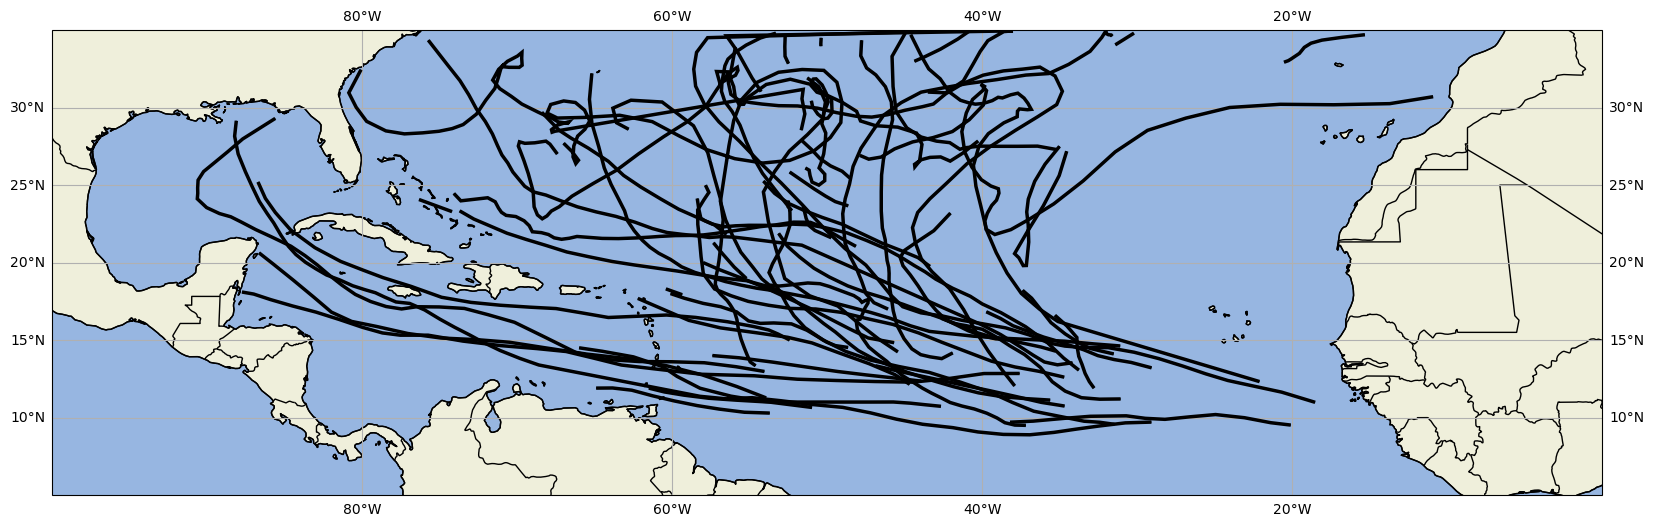

In [9]:
import cartopy.feature as cfeature
from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib import patheffects

def plot_tracks(filtered_ib):
    filtered_ib['datetime'] = pd.to_datetime(filtered_ib['datetime'])

    events = filtered_ib.groupby('id')
    
    fig,ax = plt.subplots(figsize=(20,10),subplot_kw={"projection": ccrs.PlateCarree()})
    
    ax.add_feature(cfeature.COASTLINE)

    ax.add_feature(cfeature.BORDERS)


    ax.coastlines()
    
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
  
    for event_num , event in events:
        #print(event_num)
        #if(event_num == 8.0):   
        #print(event_num)
        #roll_events = event.set_index('datetime')[['LON','LAT']].rolling(window=1).mean()
        lon = event['LON'].values
        lat = event['LAT'].values

        vertices = [(lo, la) for lo, la in zip(lon, lat)]
        codes = [Path.MOVETO]
        [codes.append(Path.LINETO) for index in range(0, len(event) - 1)]
    
        #print(vertices)
        #print(codes)

        path = Path(vertices, codes)

        #print(path)

        patch = patches.PathPatch(path, lw = 1, fc = 'none', path_effects = [patheffects.withStroke(linewidth=2.5, foreground="black")], zorder = 5)

        ax.add_patch(patch)
        
        #ax.plot(lon,lat,transform=ccrs.PlateCarree(),linewidth=1,color='black')
        ax.set_xlim(-100, 0)
        ax.set_ylim(5, 35)
    return fig,ax

plot_tracks(ib_data_processed_6h)

In [158]:
ib_data_processed_6h

,datetime,LAT,LON,USA_WIND,id,SID
0,2000-06-23 00:00:00,9.515070,-20.08375,26.0,0.0,2000175N09340
1,2000-06-23 06:00:00,9.667420,-21.37375,30.0,0.0,2000175N09340
2,2000-06-23 12:00:00,9.990000,-23.07115,30.0,0.0,2000175N09340
3,2000-06-23 18:00:00,10.193600,-24.93630,30.0,0.0,2000175N09340
4,2000-06-24 00:00:00,10.046155,-26.60755,30.0,0.0,2000175N09340
...,...,...,...,...,...,...
1158,2005-11-28 06:00:00,30.004350,-24.02575,60.0,46.0,2005324N27312
1159,2005-11-28 12:00:00,30.210150,-20.76440,60.0,46.0,2005324N27312
1160,2005-11-28 18:00:00,30.180200,-17.31015,58.5,46.0,2005324N27312
1161,2005-11-29 00:00:00,30.251750,-13.69805,53.5,46.0,2005324N27312


In [11]:
input_dsets.sel(time='2002-09-30')

<xarray.Dataset>
Dimensions:      (longitude: 79, latitude: 42, time: 4)
Coordinates:
  * longitude    (longitude) float32 -83.0 -82.0 -81.0 -80.0 ... -7.0 -6.0 -5.0
  * latitude     (latitude) float32 43.0 42.0 41.0 40.0 39.0 ... 5.0 4.0 3.0 2.0
  * time         (time) datetime64[ns] 2002-09-30 ... 2002-09-30T18:00:00
    level        int32 ...
Data variables:
    r            (time, latitude, longitude) float32 dask.array<chunksize=(4, 42, 79), meta=np.ndarray>
    sp           (time, latitude, longitude) float32 dask.array<chunksize=(4, 42, 79), meta=np.ndarray>
    speed_shear  (time, latitude, longitude) float32 dask.array<chunksize=(4, 42, 79), meta=np.ndarray>
    sst          (time, latitude, longitude) float64 dask.array<chunksize=(4, 42, 79), meta=np.ndarray>
    u            (time, latitude, longitude) float32 dask.array<chunksize=(4, 42, 79), meta=np.ndarray>
    v            (time, latitude, longitude) float32 dask.array<chunksize=(4, 42, 79), meta=np.ndarray>
    vo           (time, latitude, longitude) float32 dask.array<chunksize=(4, 42, 79), meta=np.ndarray>
    rand_arr     (time, latitude, longitude) float64 dask.array<chunksize=(4, 42, 79), meta=np.ndarray>
    cor_params   (time, latitude, longitude) float32 9.944e-05 ... 5.088e-06

In [119]:
# iterate through rows iterrows

final_data = []
max_len = ib_data_processed_6h.groupby('id').size().max()  # assuming max length is 3 hours per storm
for id_number,group in ib_data_processed_6h.groupby('id'):
    events_data = []
    for index,row in group.iterrows():
        lat = int(row['LAT'])
        lon = int(row['LON'])
        time = row['datetime']
        
        #We want data in a 5x5 latitude/longitude grid centered on the cyclone latitude/longitude
        latmin = lat - 2
        latmax = lat + 2
        lonmin = lon - 2
        lonmax = lon + 2
        sel_data = input_dsets.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax), time=time)
        
            
        final_xr = sel_data.rename({'latitude': 'y', 'longitude': 'x'})
        final_xr['x'] = np.arange(0,final_xr.sizes['x'])
        final_xr['y'] = np.arange(0,final_xr.sizes['y'])
        
        # fill NaN values with zeros along the x and y dimensions
        for jj in final_xr.data_vars:
            final_xr[jj].fillna(0)  # Fill NaN values
        
        #Recall that we are trying to predict the wind speed.
        #Hence, our target is USA_WIND
        final_xr['target'] = row['USA_WIND']    
        events_data.append(final_xr)
    
    final_event = xr.concat(events_data,dim='time')
    id
    #Pad data with zeros up to the maximum time
    if len(final_event.time) <= max_len:
        new_time = pd.date_range(start=final_event['time'].min().values, periods=max_len ,freq='6h')
        padded_data = final_event.reindex(time=new_time, fill_value=0.0)
    else:
        padded_data = final_event
    
    lead_time = np.arange(0,max_len*6 ,6)
    padded_data['lead'] = ('time', lead_time)
    padded_data = padded_data.assign_coords({'lead': padded_data['lead'].astype(int)})
    
    # swap time and lead dimensions
    padded_data = padded_data.swap_dims({'time': 'lead'})
    padded_data['id'] = id_number 
    
    # convert the time dimension to a variable
    final_data.append(padded_data)


final_input_padded = xr.concat(final_data, dim='id')
final_input_padded




/Users/nalex2023/miniconda3/envs/nma/lib/python3.12/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/Users/nalex2023/miniconda3/envs/nma/lib/python3.12/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/Users/nalex2023/miniconda3/envs/nma/lib/python3.12/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/Users/nalex2023/miniconda3/envs/nma/lib/python3.12/site-packages/xarr

<xarray.Dataset>
Dimensions:      (x: 5, y: 5, id: 69, lead: 80)
Coordinates:
  * x            (x) int64 0 1 2 3 4
  * y            (y) int64 0 1 2 3 4
    time         (id, lead) datetime64[ns] 2000-06-23 ... 2005-12-09T06:00:00
    level        int32 925
  * lead         (lead) int64 0 6 12 18 24 30 36 ... 438 444 450 456 462 468 474
  * id           (id) float64 0.0 1.0 1.5 1.667 2.0 ... 42.0 43.0 44.0 45.0 46.0
Data variables:
    r            (id, lead, y, x) float64 90.72 90.94 86.49 ... 0.0 0.0 0.0
    sp           (id, lead, y, x) float64 1.014e+05 1.014e+05 ... 0.0 0.0
    speed_shear  (id, lead, y, x) float64 8.288 6.2 3.47 1.145 ... 0.0 0.0 0.0
    sst          (id, lead, y, x) float64 299.8 299.8 300.5 ... 0.0 0.0 0.0
    u            (id, lead, y, x) float64 -3.772 -6.573 -8.691 ... 0.0 0.0 0.0
    v            (id, lead, y, x) float64 -5.732 -7.045 -5.061 ... 0.0 0.0 0.0
    vo           (id, lead, y, x) float64 4.975e-07 9.506e-06 ... 0.0 0.0
    rand_arr     (id, lead, y, x) float64 0.3126 0.2106 0.5885 ... 0.0 0.0 0.0
    cor_params   (id, lead, y, x) float64 2.782e-05 2.782e-05 ... 0.0 0.0
    target       (id, lead) float64 26.0 30.0 30.0 30.0 30.0 ... 0.0 0.0 0.0 0.0

In [ ]:

"""
import dask
import numpy as np
import xarray as xr

def process_row(row, input_dsets):
    lat = int(row['LAT'])
    lon = int(row['LON'])
    time = row['datetime']
    latmin = lat - 5
    latmax = lat + 5
    lonmin = lon - 5
    lonmax = lon + 5

    try:
        # Select the data for the given lat/lon/time
        sel_data = input_dsets.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax), time=time)
    
    except KeyError:
        # If data is not found, return None (will be filtered out later)
        print(f"Data not found for SID: {row['SID']} at time {time} with lat {lat} and lon {lon}")
        return None

    # Add SID and wind speed as new variables
    sel_data['id'] = row['id']
    wind_speed = row['USA_WIND']

    # Rename dimensions and set coordinate ranges
    final_xr = sel_data.rename({'latitude': 'y', 'longitude': 'x'})
    final_xr['x'] = np.arange(0, len(final_xr['x']), 1)
    final_xr['y'] = np.arange(0, len(final_xr['y']), 1)
    final_xr = final_xr.fillna(0)  # Fill NaN values with zeros
    final_xr['target'] = wind_speed

    return final_xr

# Wrap your row processing in dask.delayed
delayed_results = []
for index, row in ib_data_processed.iterrows():
    delayed_result = dask.delayed(process_row)(row, input_dsets)
    delayed_results.append(delayed_result)

# Compute in parallel and filter out None results
final_data = dask.compute(*delayed_results)
final_data = [ds for ds in final_data if ds is not None]

# Concatenate along 'time' dimension
final_data_xr = xr.concat(final_data, dim='time')
"""

In [120]:
final_input_computed =final_input_padded.compute()

In [122]:
final_input_padded.to_netcdf('/Users/nalex2023/main/ml-hurricane-intensity/test_folder/input_predictands.nc')

In [ ]:
def convert_to_numpy(dset):
    nump_values = dset.values
    nump_values = np.array(dset)
    df_data = None
              
    return df_data,nump_values


df, nump_values = convert_to_numpy(final_data)


In [123]:
input_final = xr.open_dataset('/Users/nalex2023/main/ml-hurricane-intensity/test_folder/input_predictands.nc')


In [124]:
input_final

<xarray.Dataset>
Dimensions:      (x: 5, y: 5, id: 69, lead: 80)
Coordinates:
  * x            (x) int64 0 1 2 3 4
  * y            (y) int64 0 1 2 3 4
    time         (id, lead) datetime64[ns] ...
    level        int32 ...
  * lead         (lead) int64 0 6 12 18 24 30 36 ... 438 444 450 456 462 468 474
  * id           (id) float64 0.0 1.0 1.5 1.667 2.0 ... 42.0 43.0 44.0 45.0 46.0
Data variables:
    r            (id, lead, y, x) float32 ...
    sp           (id, lead, y, x) float32 ...
    speed_shear  (id, lead, y, x) float32 ...
    sst          (id, lead, y, x) float64 ...
    u            (id, lead, y, x) float32 ...
    v            (id, lead, y, x) float32 ...
    vo           (id, lead, y, x) float32 ...
    rand_arr     (id, lead, y, x) float64 ...
    cor_params   (id, lead, y, x) float64 ...
    target       (id, lead) float64 ...

In [125]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


In [126]:
# find the data with NaN values
nan_mask = np.isnan(input_final['r'])
# nan coords 

nan_coords = np.where(nan_mask)
nan_coords_df = pd.DataFrame({'time': nan_coords[0], 'y': nan_coords[1], 'x': nan_coords[2], 'id': input_final['id'].values[nan_coords[0]]})

nan_coords_df

,time,y,x,id
0,7,19,0,5.0
1,7,19,0,5.0
2,7,19,1,5.0
3,7,19,1,5.0
4,7,19,2,5.0
...,...,...,...,...
2165,54,38,4,36.0
2166,54,38,4,36.0
2167,54,38,4,36.0
2168,54,38,4,36.0


In [127]:
final_padded_filled = final_input_padded.fillna(0)  # Fill NaN values with zeros

In [128]:
input_final = final_padded_filled

In [129]:
x_data = input_final[['u', 'v', 'vo', 'speed_shear', 'sp', 'r', 'cor_params']].to_array(dim='variable')


In [130]:
x_data

<xarray.DataArray (variable: 7, id: 69, lead: 80, y: 5, x: 5)>
array([[[[[-3.77186966e+00, -6.57255077e+00, -8.69095230e+00,
           -8.28010273e+00, -6.33566475e+00],
          [-8.86057854e-01, -1.16242409e+00, -3.26601887e+00,
           -2.82555962e+00, -2.99458790e+00],
          [ 4.31062508e+00,  5.37414360e+00,  4.57712078e+00,
            4.16627312e+00,  4.33776855e+00],
          [ 4.99290562e+00,  4.76342201e+00,  5.39635134e+00,
            4.44140625e+00,  3.42353725e+00],
          [ 3.11632538e+00,  2.54878616e+00,  2.53521442e+00,
            1.61604881e+00,  1.04234123e+00]],

         [[-3.13153744e+00, -7.32022190e+00, -1.04996738e+01,
           -9.94940662e+00, -6.76378632e+00],
          [-2.17288971e+00, -3.01802921e+00, -3.37089062e+00,
           -3.06614685e+00,  1.21345520e-02],
          [ 2.94236279e+00,  4.25633907e+00,  5.78622580e+00,
            5.69616079e+00,  3.14593697e+00],
          [ 3.79737186e+00,  4.29952049e+00,  4.42413235e+00,
            3.08671474e+00,  2.51054001e+00],
          [ 1.48033333e+00,  1.34955215e+00,  1.38779926e+00,
...
            0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
            0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
            0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
            0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
            0.00000000e+00,  0.00000000e+00]],

         [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
            0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
            0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
            0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
            0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
            0.00000000e+00,  0.00000000e+00]]]]])
Coordinates:
  * x         (x) int64 0 1 2 3 4
  * y         (y) int64 0 1 2 3 4
    time      (id, lead) datetime64[ns] 2000-06-23 ... 2005-12-09T06:00:00
    level     int32 925
  * lead      (lead) int64 0 6 12 18 24 30 36 42 ... 438 444 450 456 462 468 474
  * id        (id) float64 0.0 1.0 1.5 1.667 2.0 ... 42.0 43.0 44.0 45.0 46.0
  * variable  (variable) object 'u' 'v' 'vo' 'speed_shear' 'sp' 'r' 'cor_params'

In [132]:
#x_data = input_final[['u', 'v', 'vo', 'speed_shear', 'sp', 'r', 'cor_params']].to_array(dim='variable')

id_groups = input_final['id'].to_dataframe()


x_data_ordered = x_data.transpose('id','lead','y','x','variable')

y_data = input_final['target']


# expand dimensions to match the input shape
#y_data = np.expand_dims(y_data, axis=-1)
# expand dims in xarray 

y_data_expanded = np.expand_dims(y_data, axis=-1)

y_data_expanded.shape


(69, 80, 1)

In [133]:
#x_train, x_test, y_train, y_test = train_test_split(x_data_ordered, y_data, test_size=0.2, random_state=1)



test_size = 0.2


x_train, x_test, y_train, y_test = train_test_split(x_data_ordered, y_data, test_size=test_size, random_state=1)


x_train_final = x_train.values

x_test_final = x_test.values

y_train_final = y_train.values

y_test_final = y_test.values



In [134]:
# scaling the data
from sklearn.preprocessing import MinMaxScaler

# Loading the MINMAX scalar for normalizing by each varaiable
from sklearn.preprocessing import StandardScaler , MinMaxScaler
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()

y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()



#x_train_scaled = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
#x_test_scaled = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)
x_train_scaled = x_train_scaler.fit_transform(x_train_final.reshape(-1, x_train_final.shape[-1])).reshape(x_train_final.shape)
y_train_scaled = y_train_scaler.fit_transform(y_train_final.reshape(-1,1)).reshape(y_train_final.shape)

x_test_scaled = x_test_scaler.fit_transform(x_test_final.reshape(-1, x_test_final.shape[-1])).reshape(x_test_final.shape)
y_test_scaled = y_test_scaler.fit_transform(y_test_final.reshape(-1,1)).reshape(y_test_final.shape)



In [135]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.regularizers import l1_l2
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
# import timedistributed as tfd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, TimeDistributed, LSTM, Reshape
from tensorflow.keras.layers import Masking
# import adam
from tensorflow.keras.optimizers import Adam

In [136]:
from keras import layers

# how to mask the data using tf cast not loss 



In [137]:
def masked_mse(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, 0.0), tf.float32)
    squared_error = tf.square(y_true - y_pred)
    masked_loss = tf.reduce_sum(squared_error * mask) / (tf.reduce_sum(mask) + 1e-6)
    return masked_loss

model = Sequential()
model.add(TimeDistributed(
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    input_shape=(140, 5, 5, 7)
))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(64, return_sequences=True))  # <--- important!
model.add(TimeDistributed(Dense(1)))

model.summary()

/Users/nalex2023/miniconda3/envs/nma/lib/python3.12/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_6              │ (None, 140, 5, 5, 16)  │         1,024 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 140, 400)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 140, 64)        │       119,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 140, 1)         │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,129 (469.25 KB)

 Trainable params: 120,129 (469.25 KB)

 Non-trainable params: 0 (0.00 B)

In [139]:
model.compile(optimizer='adam', metrics=['mae'] , loss=masked_mse)

In [140]:
model.fit(x_train_scaled, y_train_scaled, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 745ms/step - loss: 0.1602 - mae: 0.2373 - val_loss: 0.1065 - val_mae: 0.1605
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.1157 - mae: 0.1473 - val_loss: 0.0361 - val_mae: 0.0591
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0494 - mae: 0.0563 - val_loss: 0.0541 - val_mae: 0.0961
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0625 - mae: 0.0997 - val_loss: 0.0229 - val_mae: 0.1758
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0217 - mae: 0.1828 - val_loss: 0.0249 - val_mae: 0.2526
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0371 - mae: 0.2648 - val_loss: 0.0291 - val_mae: 0.2934
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0359 - mae: 0.2992 - val_loss: 0.0218 - val_mae: 0.2805
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0252 - mae: 0.2831 - val_loss: 0.0258 - val_mae: 0.2678
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0269 - mae:

In [141]:
predict_x = model.predict(x_test_scaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


In [142]:
x_train.id

<xarray.DataArray 'id' (id: 55)>
array([17.6     , 40.5     , 34.5     , 34.666667, 32.      , 31.      ,
       22.666667, 14.      , 38.666667,  1.666667, 36.      , 30.      ,
       38.5     ,  6.5     ,  9.5     , 12.      , 27.      , 17.      ,
        5.5     , 10.      ,  0.      , 40.666667, 28.      , 40.      ,
       44.      ,  8.      , 15.      , 22.5     , 21.      , 29.5     ,
       39.      , 16.      ,  2.      ,  9.      , 20.      , 19.      ,
       29.666667,  6.666667, 37.      , 11.      , 46.      , 13.      ,
       34.      , 17.333333,  4.      , 31.666667,  5.      , 45.      ,
        1.      ,  9.666667, 42.      ,  3.      ,  6.      ,  7.      ,
       25.      ])
Coordinates:
    level    int32 925
  * id       (id) float64 17.6 40.5 34.5 34.67 32.0 ... 42.0 3.0 6.0 7.0 25.0

In [144]:
predict_x_invert_scaled = y_test_scaler.inverse_transform(predict_x.reshape(-1,1)).reshape(predict_x.shape)

predict_x_invert_xr = xr.DataArray(predict_x_invert_scaled,
                                   dims=['id', 'lead', 'target'],
                                   coords={'id': x_test['id'].values,
                                           'lead': x_test['lead'].values,
                                           'target': ['target']})


predict_x_invert_xr

<xarray.DataArray (id: 14, lead: 80, target: 1)>
array([[[31.587288 ],
        [40.706364 ],
        [35.58059  ],
        ...,
        [13.323048 ],
        [13.33598  ],
        [13.3480835]],

       [[15.649684 ],
        [24.15412  ],
        [27.883047 ],
        ...,
        [53.985126 ],
        [52.622913 ],
        [51.239925 ]],

       [[27.789557 ],
        [38.999493 ],
        [42.159233 ],
        ...,
...
        ...,
        [13.569613 ],
        [13.564577 ],
        [13.559953 ]],

       [[22.258408 ],
        [28.217169 ],
        [33.809166 ],
        ...,
        [47.633747 ],
        [45.88214  ],
        [44.171757 ]],

       [[25.946777 ],
        [31.037437 ],
        [28.375515 ],
        ...,
        [13.104697 ],
        [13.128298 ],
        [13.151036 ]]], dtype=float32)
Coordinates:
  * id       (id) float64 41.0 22.0 17.5 23.5 43.0 ... 1.5 26.0 32.5 23.0 35.0
  * lead     (lead) int64 0 6 12 18 24 30 36 42 ... 438 444 450 456 462 468 474
  * target   (target) <U6 'target'

In [145]:
y_test

<xarray.DataArray 'target' (id: 14, lead: 80)>
array([[46.  , 51.  , 56.  , ...,  0.  ,  0.  ,  0.  ],
       [26.  , 30.  , 31.  , ...,  0.  ,  0.  ,  0.  ],
       [33.5 , 36.75, 35.  , ...,  0.  ,  0.  ,  0.  ],
       ...,
       [63.  ,  0.  , 70.5 , ...,  0.  ,  0.  ,  0.  ],
       [41.  , 47.5 , 56.  , ...,  0.  ,  0.  ,  0.  ],
       [32.5 , 38.5 , 33.5 , ...,  0.  ,  0.  ,  0.  ]])
Coordinates:
    time     (id, lead) datetime64[ns] 2005-09-03T06:00:00 ... 2004-10-13T18:...
    level    int32 925
  * lead     (lead) int64 0 6 12 18 24 30 36 42 ... 438 444 450 456 462 468 474
  * id       (id) float64 41.0 22.0 17.5 23.5 43.0 ... 1.5 26.0 32.5 23.0 35.0

<xarray.DataArray 'target' (id: 14, lead: 80)>
array([[46.  , 51.  , 56.  , ...,  0.  ,  0.  ,  0.  ],
       [26.  , 30.  , 31.  , ...,  0.  ,  0.  ,  0.  ],
       [33.5 , 36.75, 35.  , ...,  0.  ,  0.  ,  0.  ],
       ...,
       [63.  ,  0.  , 70.5 , ...,  0.  ,  0.  ,  0.  ],
       [41.  , 47.5 , 56.  , ...,  0.  ,  0.  ,  0.  ],
       [32.5 , 38.5 , 33.5 , ...,  0.  ,  0.  ,  0.  ]])
Coordinates:
    time     (id, lead) datetime64[ns] 2005-09-03T06:00:00 ... 2004-10-13T18:...
    level    int32 925
  * lead     (lead) int64 0 6 12 18 24 30 36 42 ... 438 444 450 456 462 468 474
  * id       (id) float64 41.0 22.0 17.5 23.5 43.0 ... 1.5 26.0 32.5 23.0 35.0

In [236]:
SID = ib_data_processed_6h[ib_data_processed_6h['id'] == 22.0]['SID'].iloc[0]

ib_original = ib_data_processed[ib_data_processed['SID'] == SID]

ib_original

,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,...,USA_SEAHGT,USA_SEARAD_NE,USA_SEARAD_SE,USA_SEARAD_SW,USA_SEARAD_NW,STORM_SPEED,STORM_DIR,datetime,month,id
1088,2003240N15329,2003,64,NA,NA,FABIAN,2003-08-27 18:00:00,TS,14.6000,-30.7000,...,,,,,,15,273,2003-08-27 18:00:00,8,22
1089,2003240N15329,2003,64,NA,NA,FABIAN,2003-08-27 21:00:00,TS,14.6379,-31.4726,...,,,,,,16,274,2003-08-27 18:00:00,8,22
1090,2003240N15329,2003,64,NA,NA,FABIAN,2003-08-28 00:00:00,TS,14.7000,-32.3000,...,,,,,,17,275,2003-08-28 00:00:00,8,22
1091,2003240N15329,2003,64,NA,NA,FABIAN,2003-08-28 03:00:00,TS,14.7998,-33.2199,...,,,,,,19,276,2003-08-28 00:00:00,8,22
1092,2003240N15329,2003,64,NA,NA,FABIAN,2003-08-28 06:00:00,TS,14.9000,-34.2000,...,,,,,,19,275,2003-08-28 06:00:00,8,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1160,2003240N15329,2003,64,NA,NA,FABIAN,2003-09-05 18:00:00,TS,31.8000,-65.3000,...,,,,,,17,9,2003-09-05 18:00:00,9,22
1161,2003240N15329,2003,64,NA,NA,FABIAN,2003-09-05 21:00:00,TS,32.6151,-65.0530,...,,,,,,17,18,2003-09-05 18:00:00,9,22
1162,2003240N15329,2003,64,NA,NA,FABIAN,2003-09-06 00:00:00,TS,33.4000,-64.7000,...,,,,,,17,18,2003-09-06 00:00:00,9,22
1163,2003240N15329,2003,64,NA,NA,FABIAN,2003-09-06 03:00:00,TS,34.1866,-64.4234,...,,,,,,16,21,2003-09-06 00:00:00,9,22


/var/folders/bt/kswp83jx5mj4bn1bjkh9g4rsg_b7ks/T/ipykernel_98158/3726584396.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_ib['datetime'] = pd.to_datetime(filtered_ib['datetime'])


"\nfor ii in ib_data_processed_6h[ib_data_processed_6h['id'] == 22.0].iterrows():\n    time = ii[1]['datetime']\n    lat = ii[1]['LAT']\n    lon = ii[1]['LON']\n    lead_hour = (time - pd.Timestamp('2000-01-01')).total_seconds() / (3600 * 3)  # Convert to hours\n    ax.text(lon, lat, f'{lead_hour}h', fontsize=12, color='black', ha='center', va='center')\n"

/Users/nalex2023/miniconda3/envs/nma/lib/python3.12/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


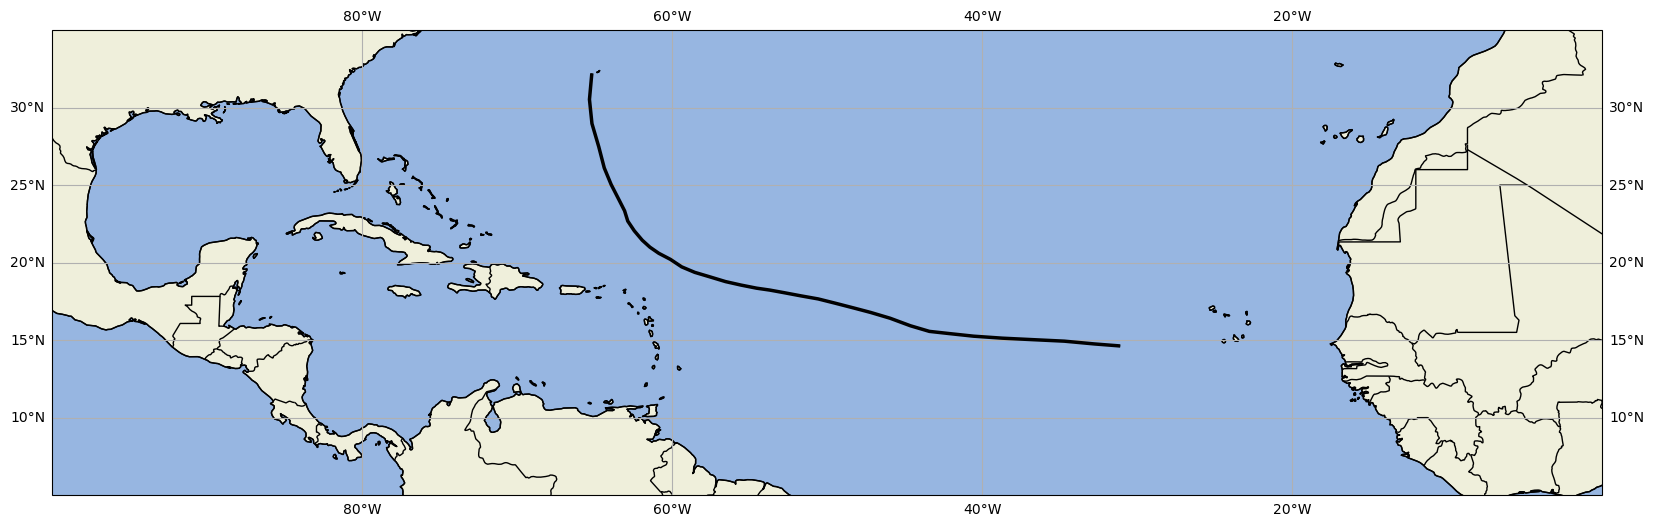

In [228]:
ib_data_processed_6h[ib_data_processed_6h['id'] == 22.0]

fig,ax = plot_tracks(ib_data_processed_6h[ib_data_processed_6h['id'] == 22.0])
"""
for ii in ib_data_processed_6h[ib_data_processed_6h['id'] == 22.0].iterrows():
    time = ii[1]['datetime']
    lat = ii[1]['LAT']
    lon = ii[1]['LON']
    lead_hour = (time - pd.Timestamp('2000-01-01')).total_seconds() / (3600 * 3)  # Convert to hours
    ax.text(lon, lat, f'{lead_hour}h', fontsize=12, color='black', ha='center', va='center')
"""

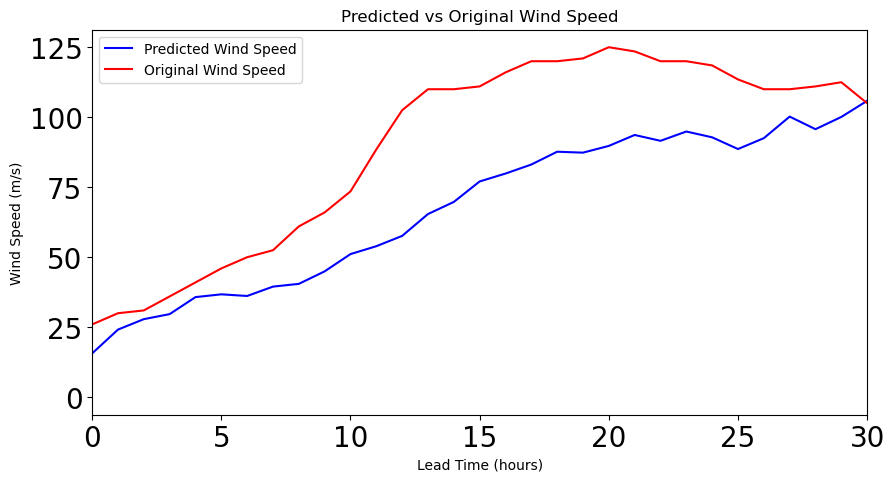

In [ ]:
test_predict = predict_x_invert_xr.isel(id=1)
original_y = y_test.isel(id=1)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(test_predict, label='Predicted Wind Speed (Hurricane FABIAN 2003)', color='blue')
ax.plot(original_y, label='Original Wind Speed', color='red')
ax.set_title('Predicted vs Original Wind Speed')
ax.set_ylabel('Wind Speed (m/s)', fontsize=20)
ax.set_xlabel('Lead Time (hours)', fontsize=20)
ax.legend()
ax.set_xlim(0,30)
ax.tick_params(axis='both', which='major', labelsize=20)

/var/folders/bt/kswp83jx5mj4bn1bjkh9g4rsg_b7ks/T/ipykernel_98158/1668877910.py:15: FutureWarning: DataFrame.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  dft_filtere = dft.replace(0.0)


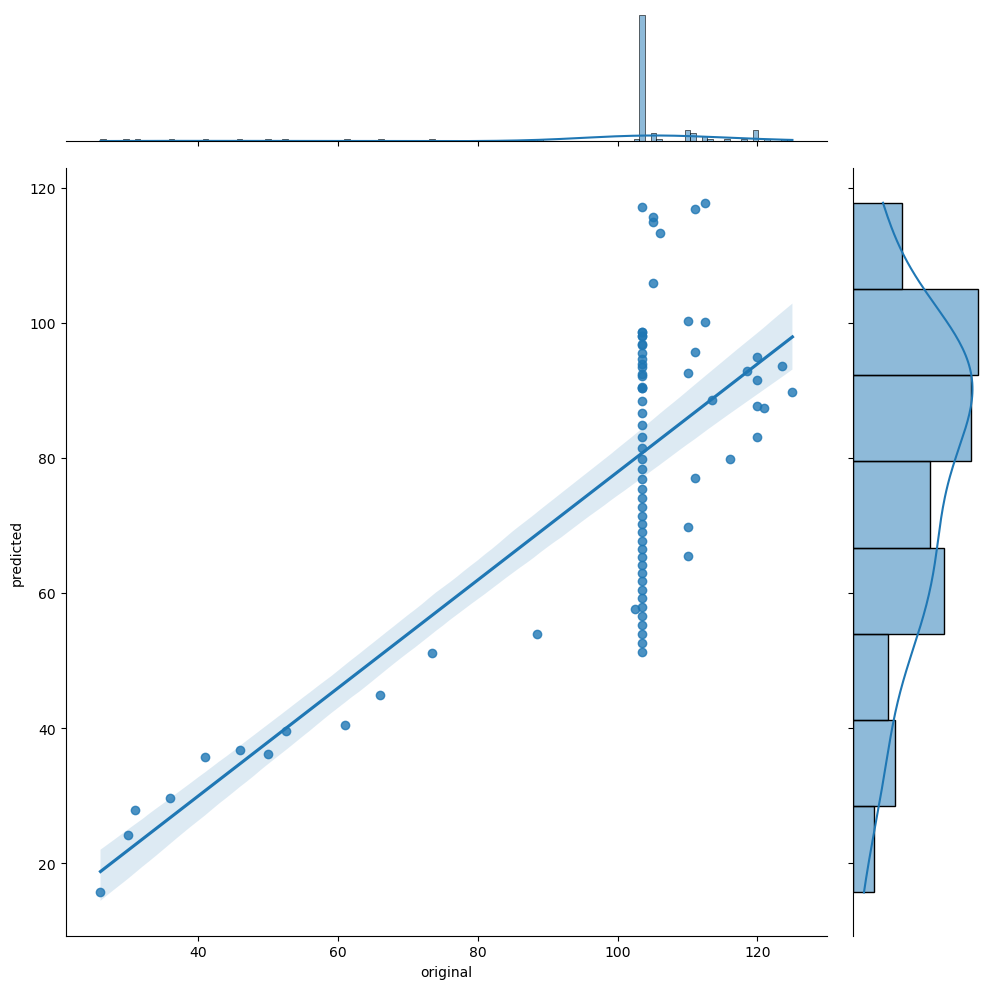

In [211]:
import seaborn as sbs

test_predict = predict_x_invert_xr.isel(id=1)
original_y = y_test.isel(id=1)

diff_predict = test_predict - original_y

x = original_y.values.reshape(-1)
y = test_predict.values.reshape(-1)
diff_predict = diff_predict.values.reshape(-1)

dft = pd.DataFrame({'original': x, 'predicted': y, 'diff': diff_predict})

# set 0.0 as nan
dft_filtere = dft.replace(0.0)

dft_filtere_dropped = dft_filtere.dropna(axis=0, how='any')

sbs.jointplot(x='original', y='predicted', data=dft_filtere_dropped, kind='reg', height=10)

In [157]:
predict_x_invert_xr.isel(id=11)

<xarray.DataArray (lead: 80, target: 1)>
array([[28.492506 ],
       [25.089714 ],
       [42.20918  ],
       [46.62667  ],
       [47.183144 ],
       [45.505917 ],
       [27.8095   ],
       [22.875582 ],
       [22.08826  ],
       [23.42441  ],
       [25.566229 ],
       [27.749395 ],
       [29.577177 ],
       [30.88432  ],
       [31.642328 ],
       [31.896677 ],
       [31.727072 ],
       [31.223612 ],
       [30.47338  ],
       [29.553715 ],
...
       [13.780831 ],
       [13.756978 ],
       [13.735366 ],
       [13.715763 ],
       [13.6979685],
       [13.681795 ],
       [13.6670885],
       [13.653698 ],
       [13.641498 ],
       [13.63037  ],
       [13.6202135],
       [13.610928 ],
       [13.602451 ],
       [13.594683 ],
       [13.587577 ],
       [13.581059 ],
       [13.575095 ],
       [13.569613 ],
       [13.564577 ],
       [13.559953 ]], dtype=float32)
Coordinates:
    id       float64 32.5
  * lead     (lead) int64 0 6 12 18 24 30 36 42 ... 438 444 450 456 462 468 474
  * target   (target) <U6 'target'

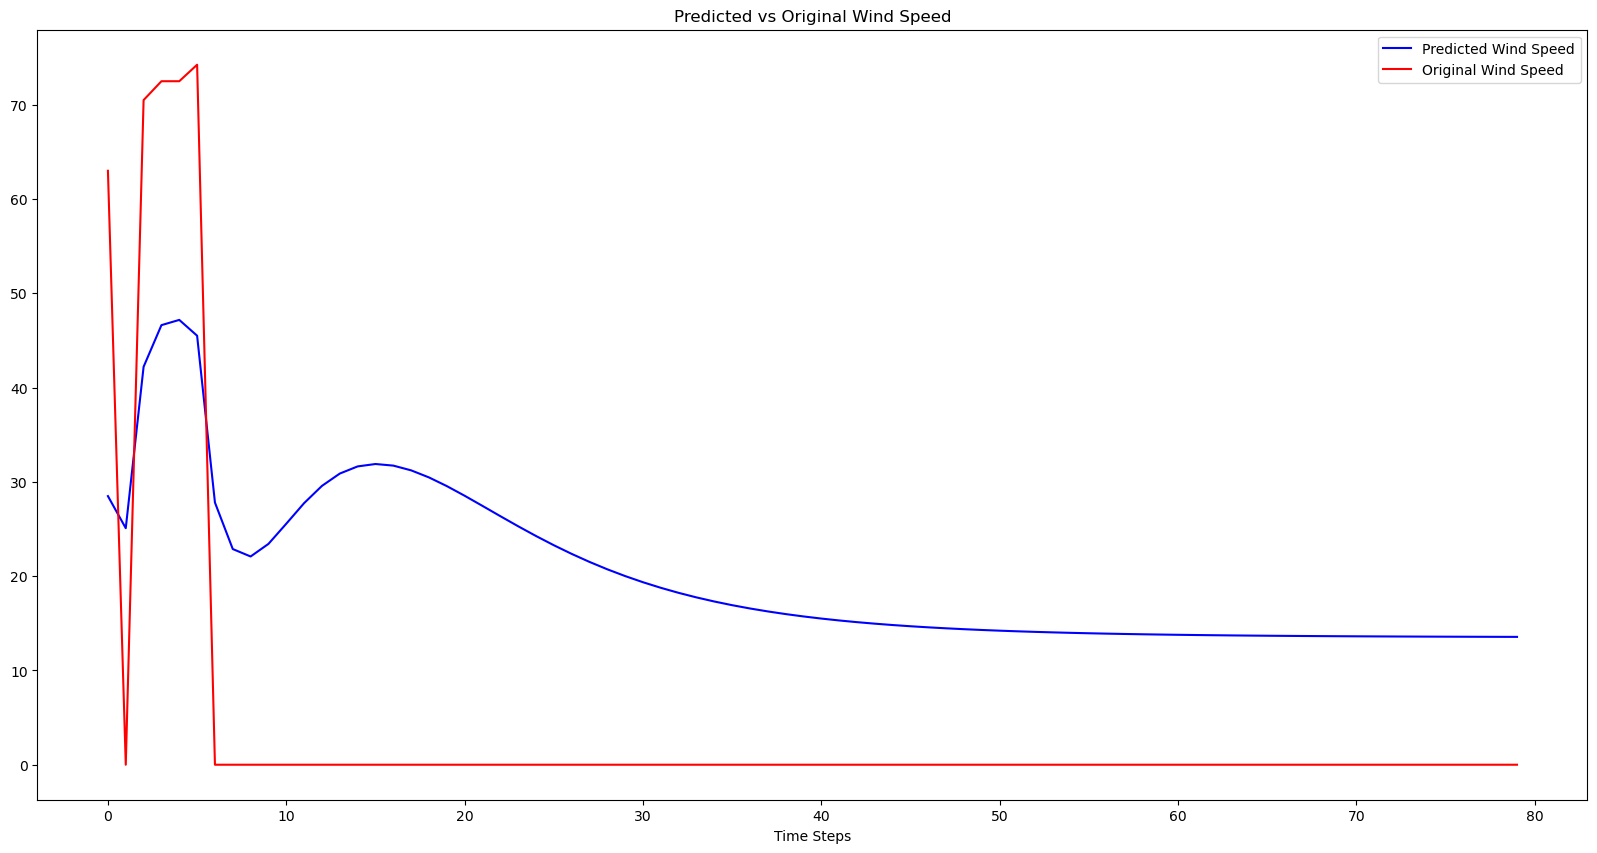

In [156]:
fig,ax = plt.subplots(figsize=(20,10))
ax.plot(test_predict, label='Predicted Wind Speed', color='blue')
ax.plot(original_y, label='Original Wind Speed', color='red')
ax.set_title('Predicted vs Original Wind Speed')
ax.set_xlabel('Time Steps')
ax.legend()

In [111]:
original_y = y_test.isel(SID=2)

y_test.SID

<xarray.DataArray 'SID' (SID: 14)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])
Coordinates:
    level    int32 925
Dimensions without coordinates: SID